### Image Classification of Pokemon

In this project an image dataset is used to train a CNN to classify Pokemon by type.

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from IPython.display import Image, display
from PIL import Image as PILimage
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
# Import Pokemon classification csv.
df = pd.read_csv('pokemon.csv')
df.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [3]:
type_counts = df['Type1'].value_counts().to_dict() # Counts of each primary type.
 
print(type_counts)
print("Number of types:", len(type_counts))

{'Water': 114, 'Normal': 105, 'Grass': 78, 'Bug': 72, 'Fire': 53, 'Psychic': 53, 'Rock': 46, 'Electric': 40, 'Poison': 34, 'Ground': 32, 'Dark': 29, 'Fighting': 29, 'Ghost': 27, 'Dragon': 27, 'Steel': 26, 'Ice': 23, 'Fairy': 18, 'Flying': 3}
Number of types: 18


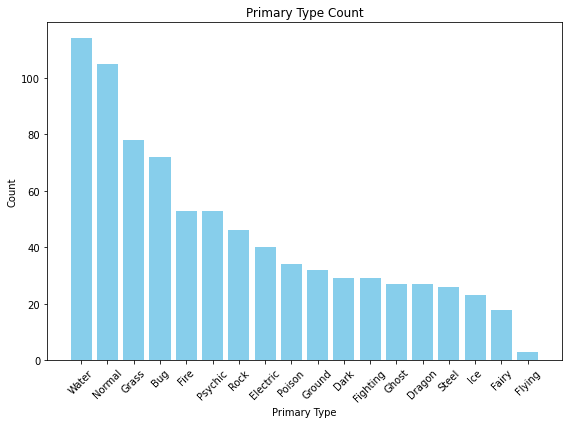

In [73]:
# Get lists of categories and counts from the dictionary.
categories = list(type_counts.keys())
counts = list(type_counts.values())

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Primary Type')
plt.ylabel('Count')
plt.title('Primary Type Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There are 18 diffeent types in the dataset, and some are fairly infrequent, so only 4 types will be used in the training and testing of the model.

In [4]:
def type_lookup(df, name):
    # Given a Pokemon name, return the primary type from the csv data.
    try:
        return df.loc[df['Name'] == name, 'Type1'].iloc[0]
    except IndexError:
        print(f"{name} not found.")

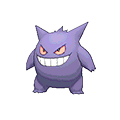

In [9]:
# Load images to create dataset
image_path = 'all/gengar.png'
display(Image(filename=image_path)) # Example image.

In [10]:
# Create a dictionary for Pokemon types, so index of type can be used as a label.
pokemon_types = {}
index = 0
for key in type_counts:
    pokemon_types[key] = index
    index += 1
print(pokemon_types)

{'Water': 0, 'Normal': 1, 'Grass': 2, 'Bug': 3, 'Fire': 4, 'Psychic': 5, 'Rock': 6, 'Electric': 7, 'Poison': 8, 'Ground': 9, 'Dark': 10, 'Fighting': 11, 'Ghost': 12, 'Dragon': 13, 'Steel': 14, 'Ice': 15, 'Fairy': 16, 'Flying': 17}


In [11]:
chosen_types = ['Water', 'Normal', 'Grass', 'Bug']  #Top 4 classes chosen.

In [12]:
data = []
labels = []
folder = "all"
poke_count = 0

# Load images, do preprocessing so they are suitable for a CNN.
# Images courtsey of https://github.com/rileynwong/pokemon-images-dataset-by-type
for filename in os.listdir(folder):
    name = filename.split(".")[0]
    pokemon_type = type_lookup(df, name) # Lookup pokemon type.
    image_path = os.path.join(folder, filename)
    image = PILimage.open(image_path).convert('RGB') # Load and convert to RGB.
    
    image_numpy = np.array(image) # Convert to numpy array.
    image_numpy = image_numpy / 255.0 # Normalise pixel values.
    image_numpy = image_numpy.astype('float32') # Convert to float32.
    image_numpy = np.expand_dims(image_numpy, axis=0) # Add batch dimension (1, height, width, channels).
    image_tensor = torch.from_numpy(image_numpy)
    
    if pokemon_type in chosen_types:
        # Only add certain types, as low count frequency of some types.
        data.append(image_tensor) # Add to data.

        # Find the index for the type
        type_ind = pokemon_types[pokemon_type]
        pokemon_type_tensor = torch.tensor(type_ind, dtype=torch.long)
        labels.append(pokemon_type_tensor) # Add primary type to label data.
        poke_count += 1 # Increment count.
        print(name, pokemon_type, "processed.")

abomasnow Grass processed.
accelgor Bug processed.
aipom Normal processed.
alomomola Water processed.
ambipom Normal processed.
amoonguss Grass processed.
araquanid Water processed.
arceus Normal processed.
ariados Bug processed.
audino Normal processed.
azumarill Water processed.
azurill Normal processed.
barboach Water processed.
basculin-red-striped Water processed.
bayleef Grass processed.
beautifly Bug processed.
beedrill Bug processed.
bellossom Grass processed.
bellsprout Grass processed.
bewear Normal processed.
bibarel Normal processed.
bidoof Normal processed.
blastoise Water processed.
blissey Normal processed.
bouffalant Normal processed.
bounsweet Grass processed.
braviary Normal processed.
breloom Grass processed.
brionne Water processed.
bruxish Water processed.
budew Grass processed.
buizel Water processed.
bulbasaur Grass processed.
buneary Normal processed.
bunnelby Normal processed.
burmy Bug processed.
butterfree Bug processed.
buzzwole Bug processed.
cacnea Grass p

C:\Users\Budgey\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


delcatty Normal processed.
dewgong Water processed.
dewott Water processed.
dewpider Water processed.
diggersby Normal processed.
ditto Normal processed.
dodrio Normal processed.
doduo Normal processed.
drampa Normal processed.
ducklett Water processed.
dunsparce Normal processed.
durant Bug processed.
dustox Bug processed.
dwebble Bug processed.
eevee Normal processed.
empoleon Water processed.
escavalier Bug processed.
exeggcute Grass processed.
exeggutor Grass processed.
exploud Normal processed.
farfetchd Normal processed.
fearow Normal processed.
feebas Water processed.
feraligatr Water processed.
ferroseed Grass processed.
ferrothorn Grass processed.
finneon Water processed.
fletchling Normal processed.
floatzel Water processed.
fomantis Grass processed.
foongus Grass processed.
forretress Bug processed.
frillish Water processed.
froakie Water processed.
frogadier Water processed.
furfrou Normal processed.
furret Normal processed.
galvantula Bug processed.
gastrodon Water process

In [14]:
# Confirm image counts.
print(f"Images processed: {poke_count}")
print(f"Data length: {len(data)}")
print(f"Label list length: {len(labels)}")

Images processed: 369
Data length: 369
Label list length: 369


In [15]:
# Split into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=151)

# Confirm train/test split sizes.
print("X_train #:", len(X_train)) # Train dataset
print("X_test #:", len(X_test)) # Test dataset
print("y_train #:", len(y_train)) # Training labels
print("y_test #:", len(y_test)) # Testing labels

X_train #: 295
X_test #: 74
y_train #: 295
y_test #: 74


In [16]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [17]:
# Model to mimic a simplified.Alexnet
class CustomAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(192 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [18]:
# Remove singleton dimension and transpose if needed
X_train_transposed = [x.squeeze(0).permute(2, 0, 1) if x.dim() == 4 else x.permute(2, 0, 1) for x in X_train]
X_test_transposed = [x.squeeze(0).permute(2, 0, 1) if x.dim() == 4 else x.permute(2, 0, 1) for x in X_test]

# Convert lists to tensors
X_train_tensor = torch.stack(X_train_transposed)  # Shape: [N, 3, 120, 120]
y_train_tensor = torch.stack(y_train)  # Ensure y_train is compatible
X_test_tensor = torch.stack(X_test_transposed)  # Shape: [M, 3, 120, 120]
y_test_tensor = torch.stack(y_test)

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [105]:
# Initialize model
model = CustomAlexNet(18).to(device)
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005) # Optimizer

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    # Function to train the model.
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

In [106]:
# Train model
train_model(model, train_loader, criterion, optimizer, num_epochs=40)

Epoch [1/40], Loss: 2.8481, Accuracy: 18.31%
Epoch [2/40], Loss: 2.2031, Accuracy: 29.49%
Epoch [3/40], Loss: 2.3498, Accuracy: 27.12%
Epoch [4/40], Loss: 2.1197, Accuracy: 31.19%
Epoch [5/40], Loss: 1.5342, Accuracy: 29.15%
Epoch [6/40], Loss: 1.4243, Accuracy: 24.75%
Epoch [7/40], Loss: 1.4410, Accuracy: 23.73%
Epoch [8/40], Loss: 1.4152, Accuracy: 30.17%
Epoch [9/40], Loss: 1.4105, Accuracy: 24.07%
Epoch [10/40], Loss: 1.3989, Accuracy: 26.78%
Epoch [11/40], Loss: 1.4022, Accuracy: 28.47%
Epoch [12/40], Loss: 1.3980, Accuracy: 30.51%
Epoch [13/40], Loss: 1.4367, Accuracy: 29.49%
Epoch [14/40], Loss: 1.3975, Accuracy: 27.46%
Epoch [15/40], Loss: 1.3985, Accuracy: 27.12%
Epoch [16/40], Loss: 1.4143, Accuracy: 31.19%
Epoch [17/40], Loss: 1.4231, Accuracy: 28.47%
Epoch [18/40], Loss: 1.3931, Accuracy: 31.53%
Epoch [19/40], Loss: 1.3867, Accuracy: 30.85%
Epoch [20/40], Loss: 1.3755, Accuracy: 29.15%
Epoch [21/40], Loss: 1.3953, Accuracy: 23.73%
Epoch [22/40], Loss: 1.3959, Accuracy: 31.1

In [107]:
# Evaluate model
def evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()  # Set model to evaluation mode.
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Shape: [batch_size, 5]
            _, preds = torch.max(outputs, dim=1)  # Get predicted class.
            all_preds.extend(preds.cpu().numpy())  # Collect predictions.
            all_labels.extend(labels.cpu().numpy())  # Collect true labels.
    
    # Calculate accuracy.
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Prepare claffification report. 
    report = classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(4)], digits=2, zero_division=0)
    
    return accuracy, report

accuracy, report = evaluate_model(model, test_loader)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("Classification Report:\n", report)

Test Accuracy: 40.54%
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.47      0.82      0.60        22
     Class 1       0.33      0.55      0.41        22
     Class 2       0.00      0.00      0.00        17
     Class 3       0.00      0.00      0.00        13

    accuracy                           0.41        74
   macro avg       0.20      0.34      0.25        74
weighted avg       0.24      0.41      0.30        74



40.5% is not a great accuracy for a 4 class dataset. The largest class (water) makes up 30% of the 4 class dataset used. So, just by predicting water for every class an accuracy of around 30% could be obtained.

Improvements could be made by adding data augmentation. There are two main classes of data augementation.

Geometric: Flipping, rotating, scaling, and shearing the image.

Colour Adjustmnets: Brightness, colour saturation or contrast adjustments, colour jittering, greyscale conversion.

Other augmentation techniques include cutting out parts of images or dropping pixels, or mixing and blending images (which could be done within the same type class).

This would synthetically enlarge the small dataset (augemented images would be added to the training dataset), which could potentially improve the performance of the model.